## Implementation for CM226: Homework 3

#####  http://web.cs.ucla.edu/~sriram/courses/cm226.fall-2016/homeworks/homework3/home3.pdf


#### written by Jinhee Kim

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import pylab

In [2]:
# matrix of x_i,j
# (1000, 5000)
geno1 = open('data/mixture1.geno','r').read().strip().split()
geno1 = np.array([[np.int(i) for i in row] for row in geno1])
geno1 = np.transpose(geno1)

# prior 
# pi_1, pi_2
alpha = open('data/mixture1.alpha','r').read().strip().split()
alpha = np.array(alpha).astype(np.float)

# Bernuoulli 
# f_j,k
# (5000, 2)
freq = open('data/mixture1.freq', 'r').read().strip().split('\n')
freq = np.array([[np.float(i) for i in row.split()] for row in freq])

# membership
# z_i,k
# (1000, 2)
ganc = open('data/mixture1.ganc','r').read().strip().split('\n')
ganc = np.array([[np.int(i) for i in row.split()] for row in ganc])

# matrix of x_i,j
# (1000, 5000)
geno2 = open('data/mixture2.geno','r').read().strip().split()
geno2 = np.array([[np.int(i) for i in row] for row in geno2])
geno2 = np.transpose(geno2)

In [3]:
def init_theta(geno, K):
    eps = 1e-50
    freq = np.random.uniform(eps, 1, (geno.shape[1], K))
    alpha = np.random.exponential(1, size=(K))
    alpha /= np.sum(alpha)
    return freq, alpha

def get_log_likelihood(freq, alpha, geno):
    eps = 0
    c_llh = np.dot(geno, np.log(freq+eps))+np.dot((1-geno),(np.log(1-freq)))
    llh = np.log(alpha)+c_llh
    return llh

def get_Q(em_r, llh):
    return np.sum(em_r*llh)

def run_estep(em_freq, em_alpha, geno):
    clipping_k = -30
    llh = get_log_likelihood(em_freq, em_alpha, geno)
    max_llh = np.max(llh, 1).reshape(-1, 1)
    temp_llh = llh - max_llh 
    temp_llh = np.clip(temp_llh, clipping_k, None)
    new_r = np.exp(temp_llh - np.log(np.sum(np.exp(temp_llh), 1).reshape(-1, 1)))
    return new_r

def run_mstep(em_r, geno):
    r_sum = np.sum(em_r, 0)
    new_freq = np.dot(np.transpose(geno), em_r) / r_sum
    new_alpha = r_sum / geno.shape[0]
    return new_freq, new_alpha

def run_EM(freq, alpha, geno):
    # E-step
    new_r = run_estep(freq, alpha, geno)
    # M-step
    new_freq, new_alpha = run_mstep(new_r, geno)
    
    # cal z 
    # membership
    new_r = run_estep(freq, alpha, geno)
    new_z = new_r.argmax(axis=1)
    #row_max = new_r.max(axis=1).reshape(-1, 1)
    #new_z = np.where(new_r == row_max, 1, 0)
    
    # cal llh
    temp_new_llh = get_log_likelihood(new_freq, new_alpha, geno)
    new_llh = get_Q(new_r, temp_new_llh)

    return new_freq, new_alpha, new_llh, new_z

In [4]:
def run_multiple_EM(geno, NUM_ITER=100, NUM_RRST=1, K=2, plot=True):
    eps = 1e-50
    best = 1
    save = dict()
    for rrst in range(NUM_RRST):
        llh_list = []
        cur_freq, cur_alpha = init_theta(geno, K)

        for ite in range(NUM_ITER):
            new_freq, new_alpha, new_llh, new_z = run_EM(cur_freq, cur_alpha, geno)        
            llh_list.append(new_llh)

            if ite == 0:
                cur_llh = new_llh
            elif new_llh < cur_llh:
                pass
                #print('LL is decreasing, old:{} new:{}'.format(cur_llh, new_llh))
            elif new_llh - cur_llh < 10e-8:
                print('Stopped because the change in log likelihood < 10e-8')
                break

            cur_llh, cur_freq, cur_alpha = new_llh, new_freq, new_alpha

        save[rrst+1] = dict()
        save[rrst+1]['freq'] = new_freq
        save[rrst+1]['alpha'] = new_alpha
        save[rrst+1]['ganc'] = new_z
        save[rrst+1]['llh'] = new_llh
        save[rrst+1]['hist_llh'] = llh_list
        
        #save the solution with the highest log likelihood
        if new_llh > save[best]['llh']:
            best == rrst+1            
        
        if plot:
            x = [str(i+1) for i in range(len(llh_list))]
            plt.plot(x, llh_list, label='init '+str(rrst+1))
            plt.title('The log likelihood')
            plt.xlabel('iteration')
            plt.ylabel('log likelihood')
            pylab.legend(loc='lower right')
    if plot:
        plt.show()

    print('Running EM algorithm done.')
    return best, save

a)

Stopped because the change in log likelihood < 10e-8


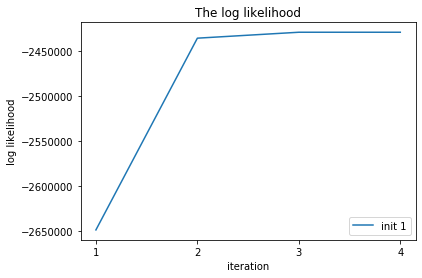

Running EM algorithm done.


In [5]:
best, save = run_multiple_EM(geno=geno1, NUM_ITER=100, NUM_RRST=1, K=2, plot=True)

b)

In [6]:
print(save[best]['alpha'])

[0.394 0.606]


c)

In [7]:
accuracy = np.sum(1*(ganc.argmax(axis=1) == save[best]['ganc']))/len(ganc.argmax(axis=1))*100
print(accuracy)

100.0


d)

Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8


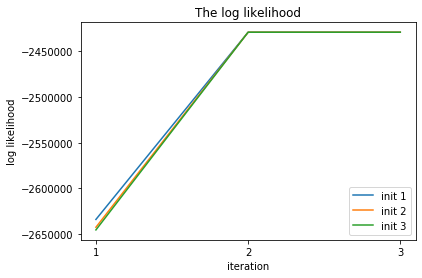

Running EM algorithm done.


In [8]:
best, save = run_multiple_EM(geno=geno1, NUM_ITER=100, NUM_RRST=3, K=2, plot=True)

In [9]:
llhs = [save[key]['llh'] for key in save.keys()]
x = list(range(1, len(llhs)+1))

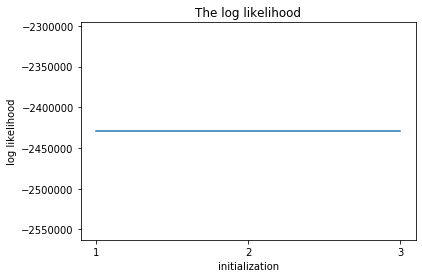

In [10]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(x, llhs)
plt.title('The log likelihood')
plt.xlabel('initialization')
plt.ylabel('log likelihood')
plt.show()

In [11]:
accuracys = [np.sum(1*(ganc.argmax(axis=1) == save[key]['ganc']))/len(ganc.argmax(axis=1))*100 for key in save.keys()]
x = list(range(1, len(accuracys)+1))

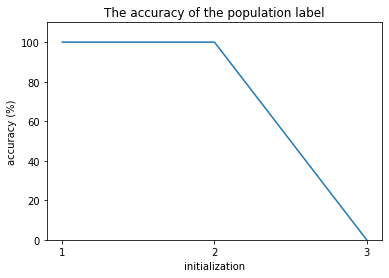

In [12]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(x, accuracys)
plt.title('The accuracy of the population label')
plt.xlabel('initialization')
plt.ylabel('accuracy (%)')
plt.ylim(ymax = 110, ymin = 0)
plt.show()

e)

In [24]:
SNP = ['10', '100', '1000', '5000']
accs = []
for snp in SNP:
    print('Running for #SNPs : {}'.format(snp))
    best, save = run_multiple_EM(geno=geno1[:,:int(snp)], NUM_ITER=100, NUM_RRST=3, K=2, plot =False)
    accs.append(np.sum(1*(ganc.argmax(axis=1) == save[best]['ganc']))/len(ganc.argmax(axis=1))*100)

Running for #SNPs : 10
Running EM algorithm done.
Running for #SNPs : 100
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Running EM algorithm done.
Running for #SNPs : 1000
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Running EM algorithm done.
Running for #SNPs : 5000
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Running EM algorithm done.


In [25]:
accs

[96.39999999999999, 0.1, 100.0, 100.0]

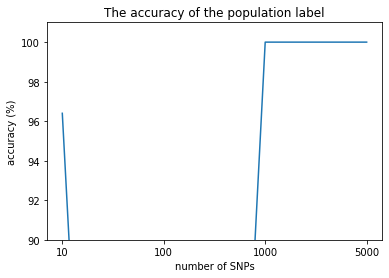

In [26]:
plt.plot(SNP, accs)
plt.title('The accuracy of the population label')
plt.xlabel('number of SNPs')
plt.ylabel('accuracy (%)')
plt.ylim(ymax = 101, ymin = 90)
plt.show()

f)

Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8


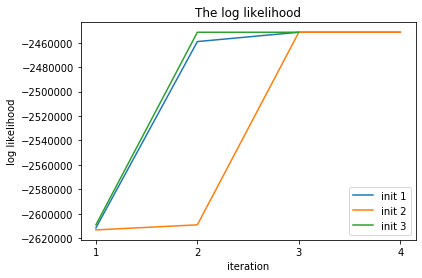

Running EM algorithm done.


In [16]:
best, save = run_multiple_EM(geno=geno2, NUM_ITER=100, NUM_RRST=3, K=2, plot=True)

In [17]:
print(save[best]['alpha'])

[0.224 0.776]


g)

In [18]:
k_list = [str(i) for i in range(1, 5)]
llh_list = []
alpha_list=[]
for k in k_list:
    print('Running for K = {}'.format(k))
    best, save = run_multiple_EM(geno=geno2, NUM_ITER=100, NUM_RRST=3, K=int(k), plot=False)
    llh_list.append(save[best]['llh'])
    alpha_list.append(('K='+k, save[best]['alpha']))

Running for K = 1
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Running EM algorithm done.
Running for K = 2
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Running EM algorithm done.
Running for K = 3
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Running EM algorithm done.
Running for K = 4
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Stopped because the change in log likelihood < 10e-8
Running EM algorithm done.


In [19]:
print(alpha_list)

[('K=1', array([1.])), ('K=2', array([0.776, 0.224])), ('K=3', array([0.768, 0.008, 0.224])), ('K=4', array([5.71998162e-01, 2.24000000e-01, 2.04001838e-01, 9.35746726e-14]))]


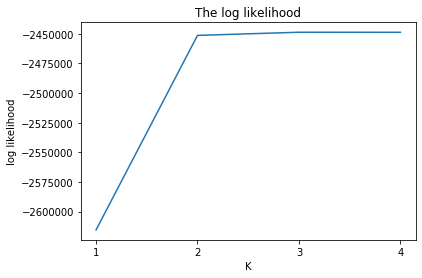

In [20]:
plt.plot(k_list, llh_list)
plt.title('The log likelihood')
plt.xlabel('K')
plt.ylabel('log likelihood')
plt.show()